# Modèle V3 de voiture autonome sur DonkeyCarSimulator

ATTENTION : 
- Modifier JPEG/JPG ou PNG
- Modifier Color (gray or 3 colors)

Verifier `#XXX`

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
import json
from PIL import Image
import base64
from io import BytesIO
import inspect
from matplotlib import pyplot as plt

In [ ]:
TIME=str(time())
MODEL_NAME = "DCDeepModelV3.2-reda-renault-speed_accel_gyro-"+TIME

STORAGE_ROOT_DIR = "drive/My Drive/ColabStorage/DonkeyCar/Simulator"
TRAINER_PROJECT_PATH = "Trainer"

DATASET_NAME = "corentin_renault_20000_record_controller"
DATASET_PATH = DATASET_NAME
DATASET_LABEL_FILENAME = "label.csv"
DATASET_LABEL_PATH = os.path.join(DATASET_PATH, DATASET_LABEL_FILENAME)

TENSORLOG_PATH = os.path.join(STORAGE_ROOT_DIR, TRAINER_PROJECT_PATH, "Log", MODEL_NAME)
os.mkdir(TENSORLOG_PATH)

BATCH_SIZE = 128

SAVE_PATH = os.path.join(STORAGE_ROOT_DIR, "Model", MODEL_NAME)
os.mkdir(SAVE_PATH)

IMAGE_SHAPE = (120,160, 3)
print("Ok.")

Ok.


# 0. Extraire la dataset

## A) zip en dataset

In [ ]:
!rm -Rf "/home/nigiva/git/dkarstream/Samples/3_controller_generated_track_0_48000"
!unzip -q "/home/nigiva/git/dkarstream/Samples/3_controller_generated_track_0_48000.zip" -d "/home/nigiva/git/dkarstream/Samples/"
!ls "/home/nigiva/git/dkarstream/Samples"

3_controller_generated_track_0_48000  3_controller_generated_track_0_48000.zip


## B) json (.eslr) en dataset
On convertit ligne par ligne les données envoyées par le serveur en :
- une image
- une ligne dans le csv label.csv

In [ ]:
!rm -Rf "corentin_renault_20000_record_controller"

In [ ]:
!cp "drive/My Drive/ColabStorage/DonkeyCar/Simulator/Dataset/corentin_renault_20000_record_controller.eslr" "corentin_renault_20000_record_controller.eslr"

In [ ]:
DATASET_JSON_FILE = DATASET_PATH + ".eslr"

IMAGE_PATH = "images"
DATASET_IMAGE_PATH = os.path.join(DATASET_PATH, IMAGE_PATH)

if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)
if not os.path.exists(DATASET_IMAGE_PATH):
    os.mkdir(DATASET_IMAGE_PATH)

In [ ]:
DATA_LABEL_FILE = open(DATASET_LABEL_PATH, "w")
DATA_LABEL_FILE.write("path,angle,throttle,speed,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z\n")#XXX
with open(DATASET_JSON_FILE, "r") as dataset_file:
    for i, line in enumerate(tqdm(dataset_file)):
        data_line = json.loads(line)
        if (data_line["msg_type"] == "telemetry"):
            image_relative_path = os.path.join(IMAGE_PATH, str(i)+".jpeg") #XXX
            image_absolute_path = os.path.join(DATASET_PATH, image_relative_path)
            Image.open(BytesIO(base64.b64decode(data_line["image"]))).save(image_absolute_path)
            # Toutes les données à ajouter dans la dataset
            data2write = [image_relative_path, str(data_line["user_angle"]), str(data_line["user_throttle"]), str(data_line["speed"]), str(data_line["accel_x"]), str(data_line["accel_y"]), str(data_line["accel_z"]), str(data_line["gyro_x"]), str(data_line["gyro_y"]), str(data_line["gyro_z"])]#XXX
            DATA_LABEL_FILE.write(",".join(data2write) + "\n")
DATA_LABEL_FILE.close()
print("ok.")

20032it [00:32, 617.42it/s]

ok.


In [ ]:
!head corentin_renault_25829_rc_thr0.5/label.csv

head: cannot open 'corentin_renault_25829_rc_thr0.5/label.csv' for reading: No such file or directory


# 1. Préparer la dataset

In [ ]:
# Obetnir les valeurs du fichier contenant les labels
raw_data = pd.read_csv(DATASET_LABEL_PATH)

# change la chemin de fichier
def change_path(path):
  return os.path.join(DATASET_PATH, path)
raw_data['path'] = raw_data['path'].map(change_path)
print(raw_data)

                                                    path  ...    gyro_z
0      corentin_renault_20000_record_controller/image...  ...  0.000194
1      corentin_renault_20000_record_controller/image...  ...  0.000208
2      corentin_renault_20000_record_controller/image...  ...  0.000190
3      corentin_renault_20000_record_controller/image...  ...  0.000131
4      corentin_renault_20000_record_controller/image...  ...  0.000086
...                                                  ...  ...       ...
20027  corentin_renault_20000_record_controller/image...  ... -0.001537
20028  corentin_renault_20000_record_controller/image...  ... -0.000755
20029  corentin_renault_20000_record_controller/image...  ...  0.000172
20030  corentin_renault_20000_record_controller/image...  ...  0.001545
20031  corentin_renault_20000_record_controller/image...  ...  0.001785

[20032 rows x 10 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce81e42d10>,
      dtype=object)

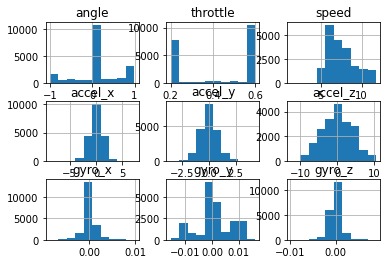

In [ ]:
raw_data.hist()

In [ ]:
#raw_data.nsmallest(3, 'accel_y', keep='last')

,path,angle,throttle,accel_x,accel_y,accel_z
3042,corentin_renault_20000_record_controller/image...,0.792145,0.2,-5.084085,-3.555202,2.529716
7674,corentin_renault_20000_record_controller/image...,0.996063,0.2,-3.435659,-3.436265,3.689241
9470,corentin_renault_20000_record_controller/image...,0.658813,0.2,-3.882110,-3.381133,3.673649


In [ ]:
#raw_data.nlargest(3, 'accel_y', keep='last')

,path,angle,throttle,accel_x,accel_y,accel_z
5865,corentin_renault_20000_record_controller/image...,0.996063,0.2,-4.422834,4.320557,-9.017086
5283,corentin_renault_20000_record_controller/image...,0.760773,0.2,1.166421,4.123014,-6.842709
8855,corentin_renault_20000_record_controller/image...,0.996063,0.2,-4.306149,4.112618,-9.304285


### Split en 3 jeux : Train, Test et Validation

In [ ]:
train_and_test_set, validation_set = train_test_split(raw_data,
                                             test_size = 0.05,#0.15
                                             shuffle = True)
train_set, test_set = train_test_split(train_and_test_set,
                                             test_size = 0.05,#0.20
                                             shuffle = True)
NBR_ROW_TRAIN_SET = train_set.shape[0]
NBR_ROW_TEST_SET = test_set.shape[0]
NBR_ROW_VALIDATION_SET = validation_set.shape[0]
print(train_set)
print(test_set)
print(validation_set)

                                                    path  ...    gyro_z
17721  corentin_renault_20000_record_controller/image...  ...  0.002714
11717  corentin_renault_20000_record_controller/image...  ... -0.001756
13697  corentin_renault_20000_record_controller/image...  ...  0.000011
12751  corentin_renault_20000_record_controller/image...  ...  0.002276
6542   corentin_renault_20000_record_controller/image...  ... -0.000119
...                                                  ...  ...       ...
4796   corentin_renault_20000_record_controller/image...  ...  0.000063
1404   corentin_renault_20000_record_controller/image...  ...  0.001746
3969   corentin_renault_20000_record_controller/image...  ... -0.001649
13591  corentin_renault_20000_record_controller/image...  ...  0.000743
12701  corentin_renault_20000_record_controller/image...  ... -0.000542

[18078 rows x 10 columns]
                                                    path  ...    gyro_z
1786   corentin_renault_20000_record_

### Traitements avec TensorData

In [ ]:
class DonkeyCarDataAugmentator:
  @staticmethod
  def normalize(img):
    return (img / 127.5) - 1.0
  
  @staticmethod
  def unnormalize(img):
    return (img + 1.0) * 127.5

  @staticmethod
  def clip_image(img):
    return tf.clip_by_value(img, clip_value_min=0, clip_value_max=255)

  @staticmethod
  def noiser(img, mean, stddev):
    transformed_img = DonkeyCarDataAugmentator.normalize(img)
    noise_img = tf.random.normal(shape=tf.shape(img), mean=mean, stddev=stddev)
    transformed_img = tf.add(transformed_img, noise_img)
    transformed_img = DonkeyCarDataAugmentator.unnormalize(transformed_img)
    transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
    return transformed_img

  @staticmethod
  def transform(img, angle, ratio_augmentation = 0.75, ratio_flip_left_right = 0.5, max_brightness = 50,
                lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3):
    
    random_do_augmentation = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_augmentation <= ratio_augmentation:
      transformed_img = tf.image.random_brightness(img, max_delta = max_brightness)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      transformed_img = tf.image.random_contrast(transformed_img, lower = lower_contrast, upper = upper_contrast)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
      
      transformed_img = tf.image.random_saturation(transformed_img, lower = lower_saturation, upper = upper_saturation)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      random_noise_gain = tf.random.uniform(shape=[], minval = 0.0, maxval = max_noise, dtype=tf.float32)
      transformed_img = DonkeyCarDataAugmentator.noiser(transformed_img, mean_noise, random_noise_gain)
    else:
      transformed_img = img
    
    random_do_flip = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_flip <= ratio_flip_left_right:
      transformed_img = tf.image.flip_left_right(transformed_img)
      angle *= -1
    
    return transformed_img, angle

In [ ]:
# Mettre dans des tensors
#train_tensor = tf.data.Dataset.from_tensor_slices(({"input" : train_set['path']}, {"angle" : train_set['angle'], "throttle" : train_set['throttle']}))
#test_tensor = tf.data.Dataset.from_tensor_slices(({"input" : test_set['path']}, {"angle" : test_set['angle'], "throttle" : test_set['throttle']}))
#validation_tensor = tf.data.Dataset.from_tensor_slices(({"input" : validation_set['path']}, {"angle" : validation_set['angle'], "throttle" : validation_set['throttle']}))
def io_to_dict(dataset):
  return ({"input" : dataset['path'], "speed_accel_gyro" : dataset[['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']]}, {"angle" : dataset['angle']})#XXX
train_tensor = tf.data.Dataset.from_tensor_slices(io_to_dict(train_set))
test_tensor = tf.data.Dataset.from_tensor_slices(io_to_dict(test_set))
validation_tensor = tf.data.Dataset.from_tensor_slices(io_to_dict(validation_set))

# Definir les fonctions de chargement des images et de mapping
def load_and_preprocess_data(inputs, outputs, augmentation_enable = True):
    file_content = tf.io.read_file(inputs['input'])
    tricolors_img = tf.cast(tf.image.decode_jpeg(file_content, channels=3), dtype=tf.float32) #XXX
    #gray_img = tf.image.rgb_to_grayscale(tricolors_img) #XXX

    # Augmentation
    if augmentation_enable:
      transformed_img, angle = DonkeyCarDataAugmentator.transform(tricolors_img, angle = outputs['angle'],
                  ratio_augmentation = 0.5, ratio_flip_left_right = 0.5, max_brightness = 50,
                  lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                  upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3)
    else:
      transformed_img = tricolors_img
      angle = outputs['angle']

    # Normalize
    normalized_img = DonkeyCarDataAugmentator.normalize(transformed_img)
    normalized_img = tf.reshape(normalized_img, IMAGE_SHAPE)
    print(normalized_img)

    return {"input": normalized_img, "speed_accel_gyro": inputs['speed_accel_gyro']}, {"angle" : angle}#XXX
  
def load_and_preprocess_data_without_augmentation(inputs, outputs):
  return load_and_preprocess_data(inputs, outputs, augmentation_enable = False)

##### FIXME
##### BUG TO FIX : Faire le repeat et le shuffle avant l'augmentation sinon duplication
#####
# Appliquer le mapping aux tensors
train_tensor_normalized = train_tensor.map(load_and_preprocess_data, num_parallel_calls=3)
test_tensor_normalized = test_tensor.map(load_and_preprocess_data_without_augmentation, num_parallel_calls=3)
validation_tensor_normalized = validation_tensor.map(load_and_preprocess_data_without_augmentation, num_parallel_calls=3)

Tensor("Reshape:0", shape=(120, 160, 3), dtype=float32)
Tensor("Reshape:0", shape=(120, 160, 3), dtype=float32)
Tensor("Reshape:0", shape=(120, 160, 3), dtype=float32)


In [ ]:
# On mélange les datasets (on fixe un nombre d'exemple tiré au sort, ici 20 000 exemples sur les 30 000)
# On demande un prechargement à l'avance de toujours 3 exemples
train_dataset = train_tensor_normalized.shuffle(18000).repeat(2).batch(BATCH_SIZE).prefetch(2)#XXX
test_dataset = test_tensor_normalized.shuffle(1000).batch(BATCH_SIZE).prefetch(2)
validation_dataset = validation_tensor_normalized.shuffle(1000).batch(BATCH_SIZE).prefetch(2)

In [ ]:
train_dataset

<PrefetchDataset shapes: ({input: (None, 120, 160, 3), speed_accel_gyro: (None, 7)}, {angle: (None,)}), types: ({input: tf.float32, speed_accel_gyro: tf.float64}, {angle: tf.float64})>

<PrefetchDataset shapes: ({input: (None, None, None, 3), speed_accel_gyro: (None, 7)}, {angle: (None, 1)}), types: ({input: tf.float32, speed_accel_gyro: tf.float64}, {angle: tf.float64})>

### Tester le rendu des IO

vect =>  [ 7.182007e+00  1.680207e+00  6.509356e-01 -4.919577e+00  2.775476e-03
 -4.662409e-03  5.377801e-04]
angle =>  -0.29803466796875
vect =>  [ 5.461941e+00 -1.215881e+00  4.235918e-01 -7.769823e-01 -7.382506e-04
  1.000458e-02  7.354458e-04]
angle =>  -0.996063232421875
vect =>  [ 5.527195e+00  1.892459e+00  5.881861e-02 -1.163173e+00  2.847195e-04
  8.006865e-03  1.209754e-04]
angle =>  0.996063232421875
vect =>  [ 8.236733e+00 -2.496028e+00  5.525365e-01 -1.634121e+00 -9.654252e-04
 -9.199442e-03 -1.477698e-03]
angle =>  1.00390625
vect =>  [ 6.090125e+00 -2.099395e-01 -7.382303e-01 -5.105543e+00  1.381923e-03
 -9.831198e-03 -1.801603e-03]
angle =>  0.7215576171875
vect =>  [ 1.123938e+01 -1.246036e+00 -1.239061e+00  5.161953e+00  3.619443e-04
  8.704776e-04  9.799340e-04]
angle =>  0.0
vect =>  [ 9.132091e+00 -7.478856e-02  2.261862e-01 -3.126478e+00  1.361445e-05
  1.008635e-04 -2.456430e-04]
angle =>  0.0
vect =>  [ 8.961637e+00  2.490869e+00  1.169742e+00 -4.586697e+00 -1.7

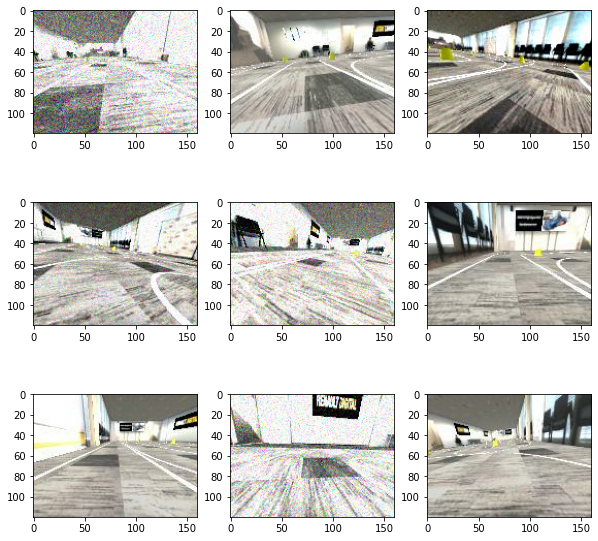

In [ ]:
plt.figure(figsize=(10, 10))
for i, o in train_dataset.take(1):
  img = i['input'].numpy()
  vect_i = i['speed_accel_gyro'].numpy()
  angle = o['angle'].numpy()
  for k in range(9):
    ax = plt.subplot(3, 3, k + 1)
    plt.imshow(DonkeyCarDataAugmentator.unnormalize(img[k]).astype("uint8"))
    print("vect => ", vect_i[k])
    print("angle => ", angle[k])

# 2. Le modèle

In [ ]:
class ModelSaver:
  """
  Save the model into a file ('model.code') as source code
  """
  def __init__(self, activate = True):
    """
    Initialize the saver
    :param activate: capture or not the source code of decorated functions
    """
    self.is_activated = activate
    self.s_init = None
    self.s_call = None
  def init(self, funct):
    """
    Capture the source code of the init function
    ---
    Use as a decoration
    Such as :
    ```
    MODEL_SAVER = ModelSaver(True)
    ...
    @MODEL_SAVER.init
    def __init__(self, name = ""):
      ...
    ```
    """
    def funct_with_params(*args, **kwargs):
      return funct(*args, **kwargs)
    if self.is_activated and self.s_init is None:
      self.s_init = inspect.getsource(funct)
    return funct_with_params

  def call(self, funct):
    """
    Capture the source code of the init function
    ---
    Use as a decoration
    Such as :
    ```
        MODEL_SAVER = ModelSaver(True)
        ...
        @MODEL_SAVER.call
        def call(self):
            ...
    ```
    """
    def funct_with_params(*args, **kwargs):
      return funct(*args, **kwargs)
    if self.is_activated and self.s_call is None:
      self.s_call = inspect.getsource(funct)
    return funct_with_params
  
  def save(self, path):
    """
    Save the source code of the model as a file
    :param path: file path
    """
    if self.s_init is not None and self.s_call is not None:
      with open(path, "w") as s:
        s.write("class DCModel(keras.Model):\n")
        s.write("  MODEL_SAVER = ModelSaver(False)\n")
        s.write(self.s_init)
        s.write(self.s_call)
    else:
      raise Exception("init or call function are not saved")
  @staticmethod
  def load(path):
    """
    Load the Model source code
    :param path: file path
    """
    with open(path, "r") as s:
      exec(s.read())

In [ ]:
LR = 0.00035

In [ ]:
MODEL_SAVER = ModelSaver(True)

class DCModel(keras.Model):
  @MODEL_SAVER.init
  def __init__(self, name="DCModel"):
    super(DCModel, self).__init__(name=name)
    #self.input_layer = keras.layers.Input(shape=IMAGE_SHAPE, name='input')
    self.cnn_1 = keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu', name='input')
    self.bn_1 = tf.keras.layers.BatchNormalization()

    self.cnn_2 = keras.layers.Conv2D(36, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_2 = keras.layers.BatchNormalization()

    self.cnn_3 = keras.layers.Conv2D(48, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_3 = keras.layers.BatchNormalization()

    self.cnn_4 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_4 = keras.layers.BatchNormalization()

    self.cnn_5 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_5 = keras.layers.BatchNormalization()

    self.drop_1 = keras.layers.Dropout(0.2)

    self.flat = keras.layers.Flatten()

    self.middle_input = keras.layers.Dense(7, name='speed_accel_gyro')
    self.bn_middle = keras.layers.BatchNormalization()
    self.merge = keras.layers.Concatenate()

    self.dense_1 = keras.layers.Dense(100, kernel_initializer='he_uniform', activation='elu')
    self.bn_6 = keras.layers.BatchNormalization()
    self.drop_2 = keras.layers.Dropout(0.1)

    self.dense_2 = keras.layers.Dense(50, kernel_initializer='he_uniform', activation='elu')
    self.bn_7 = keras.layers.BatchNormalization()
    self.drop_3 = keras.layers.Dropout(0.1)

    self.dense_3 = keras.layers.Dense(25, kernel_initializer='he_uniform', activation='elu')
    self.bn_8 = keras.layers.BatchNormalization()

    self.output_layer_1 = keras.layers.Dense(1, activation='linear', name='angle')
    #self.output_layer_2 = keras.layers.Dense(1, activation='linear', name='throttle')
  
  @MODEL_SAVER.call
  @tf.function
  def call(self, inputs, training=False):
    l = self.cnn_1(inputs['input'])
    l = self.bn_1(l)
    
    l = self.cnn_2(l)
    l = self.bn_2(l)

    l = self.cnn_3(l)
    l = self.bn_3(l)

    l = self.cnn_4(l)
    l = self.bn_4(l)

    l = self.cnn_5(l)
    l = self.bn_5(l)

    l = self.drop_1(l)

    l = self.flat(l)

    m = self.middle_input(inputs['speed_accel_gyro'])
    m = self.bn_middle(m)

    l = self.merge([l, m])

    l = self.dense_1(l)
    l = self.bn_6(l)
    l = self.drop_2(l)

    l = self.dense_2(l)
    l = self.bn_7(l)
    l = self.drop_3(l)

    l = self.dense_3(l)
    l = self.bn_8(l)
    
    return {'angle' : self.output_layer_1(l)}

model = DCModel(name='DonkeyCarModel')

optimizer = keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer,loss=keras.losses.MSE, metrics=["mse"])

## 3. L'entrainement

In [ ]:
#@title Les hyperparamètres de l'entrainement
INITIAL_EPOQUE = 17
NBR_EPOQUES = 80
NBR_EPOQUES_APRES_EARLY_STOPPING = 4

In [ ]:
# Définir mes callback

cb = [
    #keras.callbacks.EarlyStopping(patience=NBR_EPOQUES_APRES_EARLY_STOPPING,
    #                             restore_best_weights=True),
    #keras.callbacks.TensorBoard(log_dir=TENSORLOG_PATH)
    ]


"""
 keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)
"""

# Fit mon modèle
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=NBR_EPOQUES,
          initial_epoch = INITIAL_EPOQUE,
          callbacks=cb)

Epoch 18/80
283/283 [==============================] - 57s 136ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 19/80
283/283 [==============================] - 56s 132ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 20/80
283/283 [==============================] - 58s 136ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 21/80
283/283 [==============================] - 55s 128ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 22/80
283/283 [==============================] - 55s 127ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 23/80
283/283 [==============================] - 55s 128ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 24/80
283/283 [==============================] - 58s 139ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 25/80
283/283 [===========================

# 4. Sauvegarde

In [ ]:
model.save(SAVE_PATH, save_format='tf')

In [ ]:
model.save_weights(os.path.join(SAVE_PATH, "weights.data"))
MODEL_SAVER.save(os.path.join(SAVE_PATH, "model.code"))

In [ ]:
print(MODEL_NAME)

DCDeepModelV3.2-reda-renault-speed-thr0.5-1616081089.21272


In [ ]:
model.summary()

Model: "DonkeyCarModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               multiple                  1824      
_________________________________________________________________
batch_normalization (BatchNo multiple                  96        
_________________________________________________________________
conv2d (Conv2D)              multiple                  21636     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  144       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  43248     
_________________________________________________________________
batch_normalization_2 (Batch multiple                  192       
_________________________________________________________________
conv2d_2 (Conv2D)            multiple               

In [ ]:
#Tensorboad
%load_ext tensorboard
%tensorboard --logdir="drive/My Drive/ColabStorage/DonkeyCar/Simulator/Trainer/Log"

In [ ]:
performances = model.evaluate(validation_dataset, batch_size=32)
#print("Loss Angle :", performances[0],"Loss Throttle :", performances[1],"Acc Angle :", performances[2],"Acc Throttle :", performances[3])
print(performances)

8/8 [==============================] - 2s 54ms/step - loss: 0.0193 - mse: 0.0193
[0.019318193197250366, 0.019318193197250366]
